<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://raw.githubusercontent.com/Unidata/MetPy/master/src/metpy/plots/_static/unidata_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

<h1>Advanced Surface Observations: Working with Mesonet Data</h1>
<h3>Unidata Python Workshop</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

<div style="float:right; width:250 px"><img src="http://weather-geek.net/images/metar_what.png" alt="METAR" style="height: 200px;"></div>

## Overview:

* **Teaching:** 30 minutes
* **Exercises:** 35 minutes

### Questions
1. How do I read in complicated mesonet data with Pandas?
1. How do I merge multiple Pandas DataFrames?
1. What's the best way to make a station plot of data?
1. How can I make a time series of data from one station?

### Objectives
1. <a href="#reading">Read Mesonet data with Pandas</a>
2. <a href="#merge">Merge multiple Pandas DataFrames together </a>
3. <a href="#plot">Plot mesonet data with MetPy and CartoPy</a>
4. <a href="#timeseries">Create time series plots of station data</a>

<a name="reading"></a>
# Reading Mesonet Data

In this notebook, we're going to use the Pandas library to read text-based data. Pandas is excellent at handling text, csv, and other files. However, you have to help Pandas figure out how your data is formatted sometimes. Lucky for you, mesonet data frequently comes in forms that are not the most user-friendly. Through this notebook, we'll see how these complicated datasets can be handled nicely by Pandas to create useful station plots for hand analysis or publication. 

In [1]:
# Import Pandas
import pandas as pd

### West Texas Mesonet

The [West Texas Mesonet](http://www.depts.ttu.edu/nwi/research/facilities/wtm/index.php) is a wonderful data source for researchers and storm chasers alike! We have some 5-minute observations from the entire network on 22 March 2019 that we'll analyze in this notebook.

Pandas can parse time into a nice internal storage format as we read in the file. If the time is specified in the file in a somewhat standard form, pandas will even guess at the format if you tell it which column to use. However, in this case the time is reported in a horrible format: between one and four characters that, if there are four characters, represent hours and minutes as HHMM. Let's turn take a charater string, turn it into an integer, and then use integer string formatting to write out a four character string.

In [2]:
for t in ['0', '05', '100', '1005']:
    print('{0:04d}'.format(int(t)))

0000
0005
0100
1005


Pandas can be told how to parse non-standard dates formats by writing an arbitrary function that takes a string and returns a datetime. Here's what that function looks like in this case. We can use timedelta to convert hours and minutes, and then add them to the start date using date math.

In [3]:
def parse_tx_date(v, start_date=None):
    s = '{0:04d}'.format(int(v)) # regularize the data to a four character string
    hour = pd.to_timedelta(int(s[0:2]), 'hour') 
    minute = pd.to_timedelta(int(s[2:4]), 'minute')
    return start_date + hour + minute

In [4]:
# Read in the data and handle the lines that cause issues

# Get a nice date variable cooresponding to the start time
start_date = pd.datetime.strptime('2019-03-22', '%Y-%m-%d')
print(start_date)

# Pre-apply the start date to our date parsing function, so that pandas only passes one value
from functools import partial
date_parser = partial(parse_tx_date, start_date=start_date)

filename = 'West_Texas_data/FIVEMIN_82.txt'
tx_data = pd.read_csv(filename, delimiter=',', header=None, error_bad_lines=False, warn_bad_lines=False,
                     parse_dates=[2], date_parser=date_parser
                     )
tx_data

2019-03-22 00:00:00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1,81,2019-03-22 00:00:00,54,2.337,2.334,84.90,2.864,0.199,2.842,11.810,12.950,12.030,55.080,350.80,0.00,2.855,1.195,0.0
1,2,81,2019-03-22 00:00:00,54,15.050,15.180,14.45,15.480,15.180,0.272,0.380,0.395,0.262,0.000,13.26,2812.00,NaN,NaN,NaN
2,1,81,2019-03-22 00:00:00,32,1.780,1.774,92.80,4.638,0.181,2.058,6.974,12.090,7.400,71.800,339.50,0.00,2.025,0.786,0.0
3,2,81,2019-03-22 00:00:00,32,11.840,12.540,12.23,11.520,12.860,0.239,0.233,0.165,-0.073,7.650,12.36,2570.00,NaN,NaN,NaN
4,2,81,2019-03-22 00:00:00,42,9.700,11.140,9.62,9.020,9.790,0.407,0.700,0.094,0.033,1.218,12.49,659.60,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22938,1,81,2019-03-22 23:55:00,23,9.340,9.280,269.20,6.259,1.323,13.950,13.550,14.300,13.540,68.380,302.40,0.01,7.450,7.050,0.0
22939,1,81,2019-03-22 23:56:00,60,5.947,5.898,267.00,7.330,0.949,8.560,13.300,13.650,13.460,13.880,229.60,0.00,-13.660,4.250,0.0
22940,1,81,2019-03-22 23:57:00,60,8.720,8.650,277.30,7.250,0.738,10.060,13.270,13.790,13.510,13.730,229.50,0.00,-13.810,6.325,0.0
22941,1,81,2019-03-22 23:58:00,60,9.530,9.440,275.10,8.220,1.509,12.670,13.270,13.730,13.420,14.020,229.60,0.00,-13.560,6.112,0.0


In [5]:
# Rename columns to be understandable
tx_data.columns = ['Array_ID', 'QC_flag', 'Time', 'Station_ID', '10m_scalar_wind_speed',
                 '10m_vector_wind_speed', '10m_wind_direction',
                 '10m_wind_direction_std', '10m_wind_speed_std', 
                 '10m_gust_wind_speed', '1.5m_temperature', 
                 '9m_temperature', '2m_temperature', 
                 '1.5m_relative_humidity', 'station_pressure', 'rainfall', 
                 'dewpoint', '2m_wind_speed', 'solar_radiation']
tx_data

,Array_ID,QC_flag,Time,Station_ID,10m_scalar_wind_speed,10m_vector_wind_speed,10m_wind_direction,10m_wind_direction_std,10m_wind_speed_std,10m_gust_wind_speed,1.5m_temperature,9m_temperature,2m_temperature,1.5m_relative_humidity,station_pressure,rainfall,dewpoint,2m_wind_speed,solar_radiation
0,1,81,2019-03-22 00:00:00,54,2.337,2.334,84.90,2.864,0.199,2.842,11.810,12.950,12.030,55.080,350.80,0.00,2.855,1.195,0.0
1,2,81,2019-03-22 00:00:00,54,15.050,15.180,14.45,15.480,15.180,0.272,0.380,0.395,0.262,0.000,13.26,2812.00,NaN,NaN,NaN
2,1,81,2019-03-22 00:00:00,32,1.780,1.774,92.80,4.638,0.181,2.058,6.974,12.090,7.400,71.800,339.50,0.00,2.025,0.786,0.0
3,2,81,2019-03-22 00:00:00,32,11.840,12.540,12.23,11.520,12.860,0.239,0.233,0.165,-0.073,7.650,12.36,2570.00,NaN,NaN,NaN
4,2,81,2019-03-22 00:00:00,42,9.700,11.140,9.62,9.020,9.790,0.407,0.700,0.094,0.033,1.218,12.49,659.60,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22938,1,81,2019-03-22 23:55:00,23,9.340,9.280,269.20,6.259,1.323,13.950,13.550,14.300,13.540,68.380,302.40,0.01,7.450,7.050,0.0
22939,1,81,2019-03-22 23:56:00,60,5.947,5.898,267.00,7.330,0.949,8.560,13.300,13.650,13.460,13.880,229.60,0.00,-13.660,4.250,0.0
22940,1,81,2019-03-22 23:57:00,60,8.720,8.650,277.30,7.250,0.738,10.060,13.270,13.790,13.510,13.730,229.50,0.00,-13.810,6.325,0.0
22941,1,81,2019-03-22 23:58:00,60,9.530,9.440,275.10,8.220,1.509,12.670,13.270,13.730,13.420,14.020,229.60,0.00,-13.560,6.112,0.0


The West Texas mesonet provides data on weather, agriculture, and radiation. These different observations are encoded 1, 2, and 3, respectively in the Array ID column. Let's parse out only the meteorological data for this exercise.

In [6]:
# Remove non-meteorological rows
tx_data = tx_data[tx_data['Array_ID'] == 1]
tx_data

,Array_ID,QC_flag,Time,Station_ID,10m_scalar_wind_speed,10m_vector_wind_speed,10m_wind_direction,10m_wind_direction_std,10m_wind_speed_std,10m_gust_wind_speed,1.5m_temperature,9m_temperature,2m_temperature,1.5m_relative_humidity,station_pressure,rainfall,dewpoint,2m_wind_speed,solar_radiation
0,1,81,2019-03-22 00:00:00,54,2.337,2.334,84.9,2.864,0.199,2.842,11.810,12.95,12.03,55.08,350.8,0.00,2.855,1.195,0.000
2,1,81,2019-03-22 00:00:00,32,1.780,1.774,92.8,4.638,0.181,2.058,6.974,12.09,7.40,71.80,339.5,0.00,2.025,0.786,0.000
5,1,81,2019-03-22 00:00:00,7,3.103,3.030,189.6,12.440,0.150,3.365,10.680,12.65,11.10,55.47,328.5,0.00,1.927,2.000,0.000
7,1,81,2019-03-22 00:00:00,39,2.423,2.422,118.3,1.353,0.097,2.744,11.740,13.91,12.35,48.61,349.1,0.00,1.091,1.047,0.000
9,1,81,2019-03-22 00:00:00,56,3.464,3.451,124.2,4.929,0.292,4.279,13.950,14.99,14.06,49.66,363.2,0.00,3.354,2.530,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22938,1,81,2019-03-22 23:55:00,23,9.340,9.280,269.2,6.259,1.323,13.950,13.550,14.30,13.54,68.38,302.4,0.01,7.450,7.050,0.000
22939,1,81,2019-03-22 23:56:00,60,5.947,5.898,267.0,7.330,0.949,8.560,13.300,13.65,13.46,13.88,229.6,0.00,-13.660,4.250,0.000
22940,1,81,2019-03-22 23:57:00,60,8.720,8.650,277.3,7.250,0.738,10.060,13.270,13.79,13.51,13.73,229.5,0.00,-13.810,6.325,0.000
22941,1,81,2019-03-22 23:58:00,60,9.530,9.440,275.1,8.220,1.509,12.670,13.270,13.73,13.42,14.02,229.6,0.00,-13.560,6.112,0.000


Station pressure is 600 hPa lower than it should be, so let's correct that as well!

In [7]:
# Correct presssure 
tx_data['station_pressure'] += 600
tx_data['station_pressure']

/home/travis/miniconda/envs/unidata/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0        950.8
2        939.5
5        928.5
7        949.1
9        963.2
         ...  
22938    902.4
22939    829.6
22940    829.5
22941    829.6
22942    829.5
Name: station_pressure, Length: 17279, dtype: float64

Finally, let's read in the station metadata file for the West Texas mesonet, so that we can have coordinates to plot data later on.

In [8]:
tx_stations = pd.read_csv('WestTexas_stations.csv')
tx_stations

,Location,Area,Lat,Long,Elevation,ID,4 Letter ID,LDM ID,Node,Logger ID,SHEF ID
0,5ENE Abernathy,Abernathy/Hale County,33.87538,-101.75718,3333 ft.,ABER,KARS,XARS,1365,2,ARST2
1,6WSW Adrian,Adrian/Oldham County,35.25347,-102.76158,4260 ft.,ADRI,KAD1,XAD1,1526,109,ADXT2
2,3WSW Aiken,Aiken/Hale County,34.13305,-101.56952,3321 ft.,AIKE,KAI1,XAI1,1496,79,AIKT2
3,7SSE Amarillo,Amarillo/Randall County,35.11270,-101.79964,3611 ft.,AMAS,KAM1,XAM1,1492,75,ASOT2
4,9NNE Amarillo,Amarillo/Potter County,35.33597,-101.80627,3346 ft.,AMAN,KAM2,XAM2,1495,78,AMNT2
...,...,...,...,...,...,...,...,...,...,...,...
121,2E Wall,Wall/Tom Green County,31.37882,-100.26628,1870 ft,WALL2,KWA1,XWA1,1421,57,WGST2
122,2NNE Weinert,Weinert/Haskell County,33.34468,-99.66590,1504 ft,WEIN,KWE1,XWE1,1490,73,EIST2
123,Welch,Welch/Dawson County,32.92570,-102.13232,3121 ft,WELC,KWE2,XWE2,1512,96,WEHT2
124,6NW White River Lake,White River Lake/Crosby County,33.52533,-101.16506,2704 ft.,WHIT,KWVS,XWVS,1390,27,WLST2


### Oklahoma Data

Try reading in the Oklahoma Mesonet data located in the `201903222300.mdf` file using Pandas. Check out the documentation on Pandas if you run into issues! Make sure to handle missing values as well. Also read in the Oklahoma station data from the `Oklahoma_stations.csv` file. Only read in the station ID, latitude, and longitude columns from that file.

In [9]:
# Your code here


In [10]:
def parse_ok_date(v, start_date=None):
    s = '{0:04d}'.format(int(v)) # regularize the data to a four character string
    minute = pd.to_timedelta(int(s), 'minute')
    return start_date + minute

In [11]:
# %load solutions/read_ok.py


# Cell content replaced by load magic replacement.
ok_data = pd.read_csv('201903222300.mdf', skiprows=2, delim_whitespace=True, na_values=-999,
                                          parse_dates=[2], date_parser=partial(parse_ok_date, start_date=start_date))
ok_stations = pd.read_csv('Oklahoma_stations.csv', usecols=[1,7,8])
print(ok_data.head())
print(ok_stations.head())

   STID  STNM                TIME  RELH  TAIR  WSPD  WVEC  WDIR  WDSD  WSSD  \
0  ACME   110 2019-03-22 23:00:00    31  21.3   7.3   7.2   131   8.7   1.0   
1  ADAX     1 2019-03-22 23:00:00    30  20.9   3.3   3.2   136  17.4   0.8   
2  ALTU     2 2019-03-22 23:00:00    54  20.9   7.9   7.9   151   6.1   1.2   
3  ALV2   116 2019-03-22 23:00:00    35  20.4   8.0   7.9   114   9.1   1.2   
4  ANT2   135 2019-03-22 23:00:00    27  22.0   2.6   2.5   137  19.5   0.7   

   ...  TA9M  WS2M  TS10  TB10  TS05  TS25   TS60  TR05  TR25    TR60  
0  ...  21.3   6.0  15.1  17.2  15.9  11.6   10.8  1.59  1.49    1.41  
1  ...  20.6   2.3  14.9  19.5  16.6  13.1 -998.0  1.51  1.46 -998.00  
2  ...  20.9   6.0  12.9  15.4  15.0  11.6 -998.0  2.25  2.21 -998.00  
3  ...  19.8   6.7  10.3  15.7  11.5   9.0 -998.0  1.50  1.39 -998.00  
4  ...  21.6   1.9  14.4  19.1  16.4  12.5   12.0  1.67  1.38    1.33  

[5 rows x 24 columns]
   stid      nlat      elon
0  ACME  34.80833 -98.02325
1  ADAX  34.79

<a name="merge"></a>
# Merging DataFrames

We now have two data files per mesonet - one for the data itself and one for the metadata. It would be really nice to combine these DataFrames together into one for each mesonet. Pandas has some built in methods to do this - see [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html). For this example, we'll be using the `merge` method. First, let's rename columns in the Oklahoma station DataFrame to be more understandable.

In [12]:
# Rename columns so merging can occur
ok_stations.columns = ['STID', 'LAT', 'LON']

Conveniently, we have a `STID` column in both DataFrames. Let's base our merge on that and see what we get!

In [13]:
# Merge the two data frames based on the Station ID
ok_data = pd.merge(ok_data, ok_stations, on='STID')
ok_data

,STID,STNM,TIME,RELH,TAIR,WSPD,WVEC,WDIR,WDSD,WSSD,...,TS10,TB10,TS05,TS25,TS60,TR05,TR25,TR60,LAT,LON
0,ACME,110,2019-03-22 23:00:00,31,21.3,7.3,7.2,131,8.7,1.0,...,15.1,17.2,15.9,11.6,10.8,1.59,1.49,1.41,34.80833,-98.02325
1,ADAX,1,2019-03-22 23:00:00,30,20.9,3.3,3.2,136,17.4,0.8,...,14.9,19.5,16.6,13.1,-998.0,1.51,1.46,-998.00,34.79851,-96.66909
2,ALTU,2,2019-03-22 23:00:00,54,20.9,7.9,7.9,151,6.1,1.2,...,12.9,15.4,15.0,11.6,-998.0,2.25,2.21,-998.00,34.58722,-99.33808
3,ALV2,116,2019-03-22 23:00:00,35,20.4,8.0,7.9,114,9.1,1.2,...,10.3,15.7,11.5,9.0,-998.0,1.50,1.39,-998.00,36.70823,-98.70974
4,ANT2,135,2019-03-22 23:00:00,27,22.0,2.6,2.5,137,19.5,0.7,...,14.4,19.1,16.4,12.5,12.0,1.67,1.38,1.33,34.24967,-95.66844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,WILB,105,2019-03-22 23:00:00,26,20.8,3.3,3.3,69,7.0,0.5,...,13.1,16.0,15.8,11.9,11.3,1.48,1.44,1.47,34.90092,-95.34805
116,WIST,106,2019-03-22 23:00:00,18,21.1,1.5,1.4,80,21.7,0.3,...,11.8,17.0,13.0,10.4,10.0,1.99,1.51,1.41,34.98426,-94.68778
117,WOOD,107,2019-03-22 23:00:00,27,20.1,8.4,8.3,135,8.4,1.1,...,11.3,15.0,12.3,10.1,9.5,1.54,1.56,1.79,36.42329,-99.41682
118,WYNO,108,2019-03-22 23:00:00,26,19.0,3.6,3.5,122,11.8,0.5,...,13.7,17.0,14.9,9.9,-998.0,1.85,1.60,-998.00,36.51806,-96.34222


That was nice! But what if our DataFrames don't have the same column name, and we want to avoid renaming columns? Check out the documentation for `pd.merge` and see how we can merge the West Texas DataFrames together. Also, subset the data to only be from 2300 UTC, which is when our Oklahoma data was taken. Call the new DataFrame `tx_one_time`.

In [14]:
# Your code here


In [15]:
# %load solutions/merge_texas.py


# Cell content replaced by load magic replacement.
# Find common time between TX and OK data
tx_data = pd.merge(tx_data, tx_stations, left_on='Station_ID', right_on='Logger ID')
tx_one_time = tx_data[tx_data['Time'] == '2019-3-22 23:00']
tx_one_time

,Array_ID,QC_flag,Time,Station_ID,10m_scalar_wind_speed,10m_vector_wind_speed,10m_wind_direction,10m_wind_direction_std,10m_wind_speed_std,10m_gust_wind_speed,...,Area,Lat,Long,Elevation,ID,4 Letter ID,LDM ID,Node,Logger ID,SHEF ID
276,1,81,2019-03-22 23:00:00,54,3.201,3.191,124.60,4.494,0.274,3.757,...,San Angelo/Tom Green,31.54263,-100.51328,1957 ft.,SASU,KASU,XASU,1418,54,SJST2
564,1,81,2019-03-22 23:00:00,32,2.363,1.928,283.10,34.770,0.708,3.430,...,Spur/Dickens County,33.48085,-100.87636,2287 ft.,SPUR,KSP1,XSPR,1396,32,SPST2
852,1,81,2019-03-22 23:00:00,7,11.410,11.310,156.30,7.390,1.815,16.040,...,Roaring S./Motley County,33.93635,-100.84540,2615 ft.,ROAR,KRRS,XRRS,1372,7,RRST2
1140,1,81,2019-03-22 23:00:00,39,2.422,2.392,164.40,9.020,0.535,4.279,...,Jayton (Kent Co. Airport),33.23241,-100.56778,2010 ft.,JAYT,KJTS,XJTS,1404,39,JTST2
1428,1,81,2019-03-22 23:00:00,56,4.857,4.793,165.20,9.300,0.821,6.664,...,Haskell/Haskell County,33.17473,-99.74420,1605 ft.,HASK,KHA1,XHA1,1420,56,HAXT2
1716,1,81,2019-03-22 23:00:00,59,6.825,6.811,167.30,3.654,0.781,8.720,...,Knox City/Knox County,33.44557,-99.86497,1470 ft.,KNOX,KKN1,XKN1,1423,59,KXST2
2004,1,81,2019-03-22 23:00:00,24,5.571,5.456,192.70,11.620,1.399,9.280,...,Post/Garza County,33.20033,-101.36804,2598 ft.,POST2,KPT1,XPTS,1387,24,PTST2
2292,1,81,2019-03-22 23:00:00,20,3.585,3.581,320.80,2.779,0.252,4.214,...,Friona/Parmer County,34.65450,-102.69097,4005 ft.,FRIO,KFAS,XFAS,1383,20,FAST2
2580,1,81,2019-03-22 23:00:00,3,5.826,5.721,193.90,10.870,0.996,8.620,...,Plainview/Hale County,34.17872,-101.70788,3358 ft.,PLVW,KPVS,XPVS,1367,3,PVST2
2868,1,81,2019-03-22 23:00:00,17,5.328,5.305,175.90,5.349,0.508,6.893,...,Plains/Yoakum County,33.22814,-102.83936,3711 ft.,PLAI,KPPS,XPPS,1380,17,PPST2


<a name="plot"></a>
# Creating a Station Plot

Let's say we want to plot temperature, dewpoint, and wind barbs. Given our data from the two mesonets, do we have what we need? If not, use MetPy to calculate what you need!

In [16]:
import metpy.calc as mpcalc
from metpy.units import units

# Your code here


In [17]:
# %load solutions/data_conversion.py


# Cell content replaced by load magic replacement.
ok_dewpoint = mpcalc.dewpoint_rh(ok_data['TAIR'].values * units.degC, ok_data['RELH'].values * units.percent)
ok_u, ok_v = mpcalc.wind_components(ok_data['WSPD'].values * units.mph, ok_data['WDIR'].values * units.degrees)
tx_u, tx_v = mpcalc.wind_components(tx_one_time['10m_scalar_wind_speed'].values * units.mph, tx_one_time['10m_wind_direction'].values * units.degrees)

/home/travis/miniconda/envs/unidata/lib/python3.7/site-packages/metpy/xarray.py:655: MetpyDeprecationWarning: The dewpoint_rh function was deprecated in version 0.12. This function has been renamed dewpoint_from_relative_humidity.
  return func(*args, **kwargs)


Now, let's make a Station Plot with our data using MetPy and CartoPy.

In [18]:
from metpy.plots import StationPlot
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

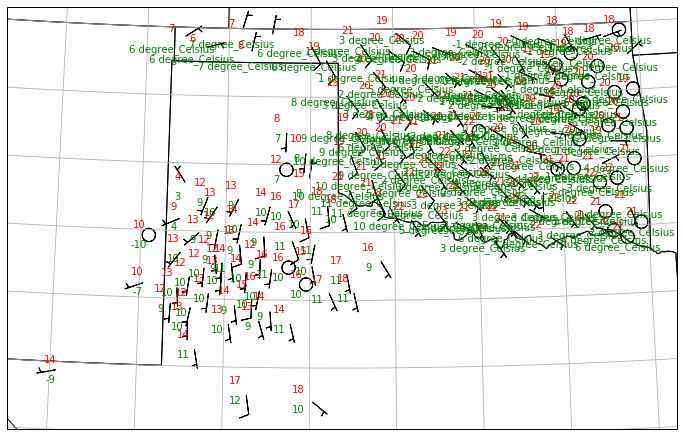

In [19]:
# Set up a plot with map features
fig = plt.figure(figsize=(12, 12))
proj = ccrs.Stereographic(central_longitude=-100, central_latitude=35)
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black')
ax.gridlines()


# Create a station plot pointing to an Axes to draw on as well as the location of points
stationplot = StationPlot(ax, ok_data['LON'].values, ok_data['LAT'].values, transform=ccrs.PlateCarree(),
                          fontsize=10)
stationplot.plot_parameter('NW', ok_data['TAIR'], color='red')
stationplot.plot_parameter('SW', ok_dewpoint, color='green')
stationplot.plot_barb(ok_u, ok_v)

# Texas Data
stationplot = StationPlot(ax, tx_one_time['Long'].values, tx_one_time['Lat'].values, transform=ccrs.PlateCarree(),
                          fontsize=10)
stationplot.plot_parameter('NW', tx_one_time['2m_temperature'], color='red')
stationplot.plot_parameter('SW', tx_one_time['dewpoint'], color='green')
stationplot.plot_barb(tx_u, tx_v)

This is an informative plot, but is rather crowded. Using MetPy's `reduce_point_density` function, try cleaning up this plot to something that would be presentable/publishable. This function will return a mask, which you'll apply to all arrays in the plotting commands to filter down the data.

In [20]:
# Oklahoma
xy = proj.transform_points(ccrs.PlateCarree(), ok_data['LON'].values, ok_data['LAT'].values)
# Reduce point density so that there's only one point within a 50km circle
ok_mask = mpcalc.reduce_point_density(xy, 50000)

# Texas

# Your code here

# Plot

# Your code here

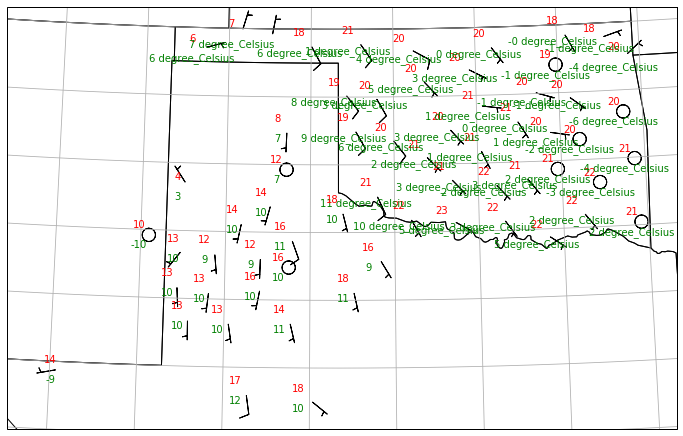

In [21]:
# %load solutions/reduce_and_plot.py


# Cell content replaced by load magic replacement.
xy = proj.transform_points(ccrs.PlateCarree(), tx_one_time['Long'].values, tx_one_time['Lat'].values)
tx_mask = mpcalc.reduce_point_density(xy, 50000)

#Plot

# Set up a plot with map features
fig = plt.figure(figsize=(12, 12))
proj = ccrs.Stereographic(central_longitude=-100, central_latitude=35)
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black')
ax.gridlines()

# Create a station plot pointing to an Axes to draw on as well as the location of points
stationplot = StationPlot(ax, ok_data['LON'].values[ok_mask], ok_data['LAT'].values[ok_mask], transform=ccrs.PlateCarree(),
                          fontsize=10)
stationplot.plot_parameter('NW', ok_data['TAIR'][ok_mask], color='red')
stationplot.plot_parameter('SW', ok_dewpoint[ok_mask], color='green')
stationplot.plot_barb(ok_u[ok_mask], ok_v[ok_mask])

# Texas Data
stationplot = StationPlot(ax, tx_one_time['Long'].values[tx_mask], tx_one_time['Lat'].values[tx_mask], transform=ccrs.PlateCarree(),
                          fontsize=10)
stationplot.plot_parameter('NW', tx_one_time['2m_temperature'][tx_mask], color='red')
stationplot.plot_parameter('SW', tx_one_time['dewpoint'][tx_mask], color='green')
stationplot.plot_barb(tx_u[tx_mask], tx_v[tx_mask])

<a name="timeseries"></a>
# Creating Time Series for Stations

What if we want to take data from all times from a single station to make a time series (or meteogram) plot? How can we easily do that with Pandas without having to aggregate the data by hand? 

In [22]:
import numpy as np

# Select daylight hours
tx_daytime = tx_data[(tx_data['Time'] >= '2019-03-22 06:00') & (tx_data['Time'] <= '2019-03-22 20:00')]

# Create sub-tables for each station
tx_grp = tx_daytime.groupby('ID')

# Get data from station DIMM
station_data = tx_grp.get_group('DIMM')

# Create hourly averaged data
# time_bins = pd.cut(station_data['Time'], np.arange(600, 2100, 100))
# xarray has groupby_bins, but pandas has cut
station_data.index=station_data['Time']
station_hourly = station_data.resample('H')


# station_hourly = station_data.groupby(time_bins)
station_hourly_mean = station_hourly.mean()
station_hourly_mean = station_hourly_mean.reset_index() # no longer index by time so that we get it back as a regular variable.

# The times are reported at the beginning of the interval, but really represent 
# the mean symmetric about the half hour. Let's fix that.
# from datetime import timedelta timedelta(minutes=30) #
station_hourly_mean['Time'] += pd.to_timedelta(30, 'minutes')
print(station_hourly_mean['Time'])
print(station_data['Time'])

0    2019-03-22 06:30:00
1    2019-03-22 07:30:00
2    2019-03-22 08:30:00
3    2019-03-22 09:30:00
4    2019-03-22 10:30:00
5    2019-03-22 11:30:00
6    2019-03-22 12:30:00
7    2019-03-22 13:30:00
8    2019-03-22 14:30:00
9    2019-03-22 15:30:00
10   2019-03-22 16:30:00
11   2019-03-22 17:30:00
12   2019-03-22 18:30:00
13   2019-03-22 19:30:00
14   2019-03-22 20:30:00
Name: Time, dtype: datetime64[ns]
Time
2019-03-22 06:00:00   2019-03-22 06:00:00
2019-03-22 06:05:00   2019-03-22 06:05:00
2019-03-22 06:10:00   2019-03-22 06:10:00
2019-03-22 06:15:00   2019-03-22 06:15:00
2019-03-22 06:20:00   2019-03-22 06:20:00
                              ...        
2019-03-22 19:40:00   2019-03-22 19:40:00
2019-03-22 19:45:00   2019-03-22 19:45:00
2019-03-22 19:50:00   2019-03-22 19:50:00
2019-03-22 19:55:00   2019-03-22 19:55:00
2019-03-22 20:00:00   2019-03-22 20:00:00
Name: Time, Length: 169, dtype: datetime64[ns]


Use the data above to make a time series plot of the instantaneous data and the hourly averaged data:

In [23]:
# Your code here


/home/travis/miniconda/envs/unidata/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


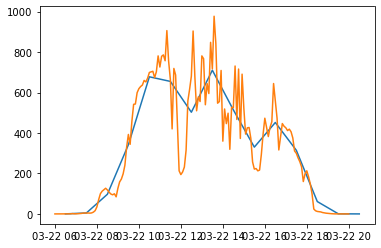

In [24]:
# %load solutions/mesonet_timeseries.py


# Cell content replaced by load magic replacement.
import matplotlib.pyplot as plt
fig = plt.figure()
ax= fig.add_subplot(111)
ax.plot(station_hourly_mean['Time'], station_hourly_mean['solar_radiation'])
ax.plot(station_data['Time'], station_data['solar_radiation'])